Development notebook for quadratic regularization correction experiments. 

What do we need: 
- CL setup (maybe initially 2D, interpretable and SMALL)
- per sample quadratic regularizer computation 
- training: SGD + regularization, joint training
- q2reg types: second order taylor, taylor block-diagonal, taylor diagonal, EWC, (see Benzig)
- error measures: forgetting (per sample), loss error, gradient error norm, gradient cosine sim. 
- viz of the loss and quadratic loss comparison 

## Setup

In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("."))

In [3]:
# --- Import Standard Libraries ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import copy
import yaml
from tqdm.notebook import tqdm
import itertools

# --- Import our custom modules ---
# Use autoreload to pick up changes in .py files without restarting kernel
%load_ext autoreload
%autoreload 2

from q2reg import regularizers
from q2reg import training

from bitbybit import networks, environments, utils, viz_utils

# --- Matplotlib Aesthetics Settings ---
plt.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "font.family": "serif",
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    'grid.alpha': 0.5,
    'grid.color': '#c0c0c0',
    'grid.linestyle': '--',
    'grid.linewidth': 0.8,
    'figure.dpi': 300,
    'figure.edgecolor': 'black',
    'figure.facecolor': 'white',
    'figure.figsize': [6, 5],
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Experiment args

In [17]:
# --- 1. Load Configuration ---
CONFIG_PATH = 'config_2D_classification.yaml'
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)
device = config['device']
print("--- Configuration ---")
print(yaml.dump(config, default_flow_style=False))

--- Configuration ---
accumulate: true
alpha: 100.0
batch_size: 32
device: cuda:4
environment: 2d_classification
environment_args:
  npz_file: sine_dataset_10.npz
  num_tasks: 9
  root: ../datasets/synthetic/
  train_ratio: 0.8
log_every_n_steps: 1
loss: CE
network:
  activation: relu
  depth: 1
  name: MLP
  width: 100
num_steps: 100
optimizer:
  lr: 0.01
  name: adam
  warmup_on: false
  weight_decay: 0.001
reg_subsample_frac: 0.1
reg_type: taylor-full
replay_subsample_frac: 1.0
scheduler:
  eps: 1e-8
  name: cosine_anneal
  patience: 20
  steps_per_task: 100
seed: 42



In [18]:
# Seed everything for reproducibility

utils.seed_everything(config['seed'])
utils.seed_worker(config['seed'])

In [19]:
# --- 2. Setup Helper ---

def get_regularizer(config):
    """Factory function for regularizers."""
    reg_name = config['reg_type']
    alpha = config['alpha']
    
    if reg_name == 'ewc':
        return regularizers.EWCRegularizer(alpha=alpha)
    if reg_name == 'taylor-diag':
        return regularizers.TaylorRegularizer(alpha=alpha, structure='diag')
    if reg_name == 'taylor-full':
        return regularizers.TaylorRegularizer(alpha=alpha, structure='full')
    
    raise ValueError(f"Unknown reg_type: {reg_name}")

Extract the environment

In [20]:
env_args = config['environment_args']
args = utils.MyArgs(**env_args)
environment_name = config['environment']
# loading the environment 
env, environment_name = environments.get_environment_from_name(environment_name, args)
num_tasks = env.number_tasks
print(f"Loaded environment: {environment_name} with {num_tasks} tasks.")

Loaded environment: 2d_classification-sine with 9 tasks.


Sampled random batch - inputs shape: torch.Size([500, 2]), labels shape: torch.Size([500])


/pub/hofmann-scratch/glanzillo/projects_mixed/viz_utils.py:352: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="center")


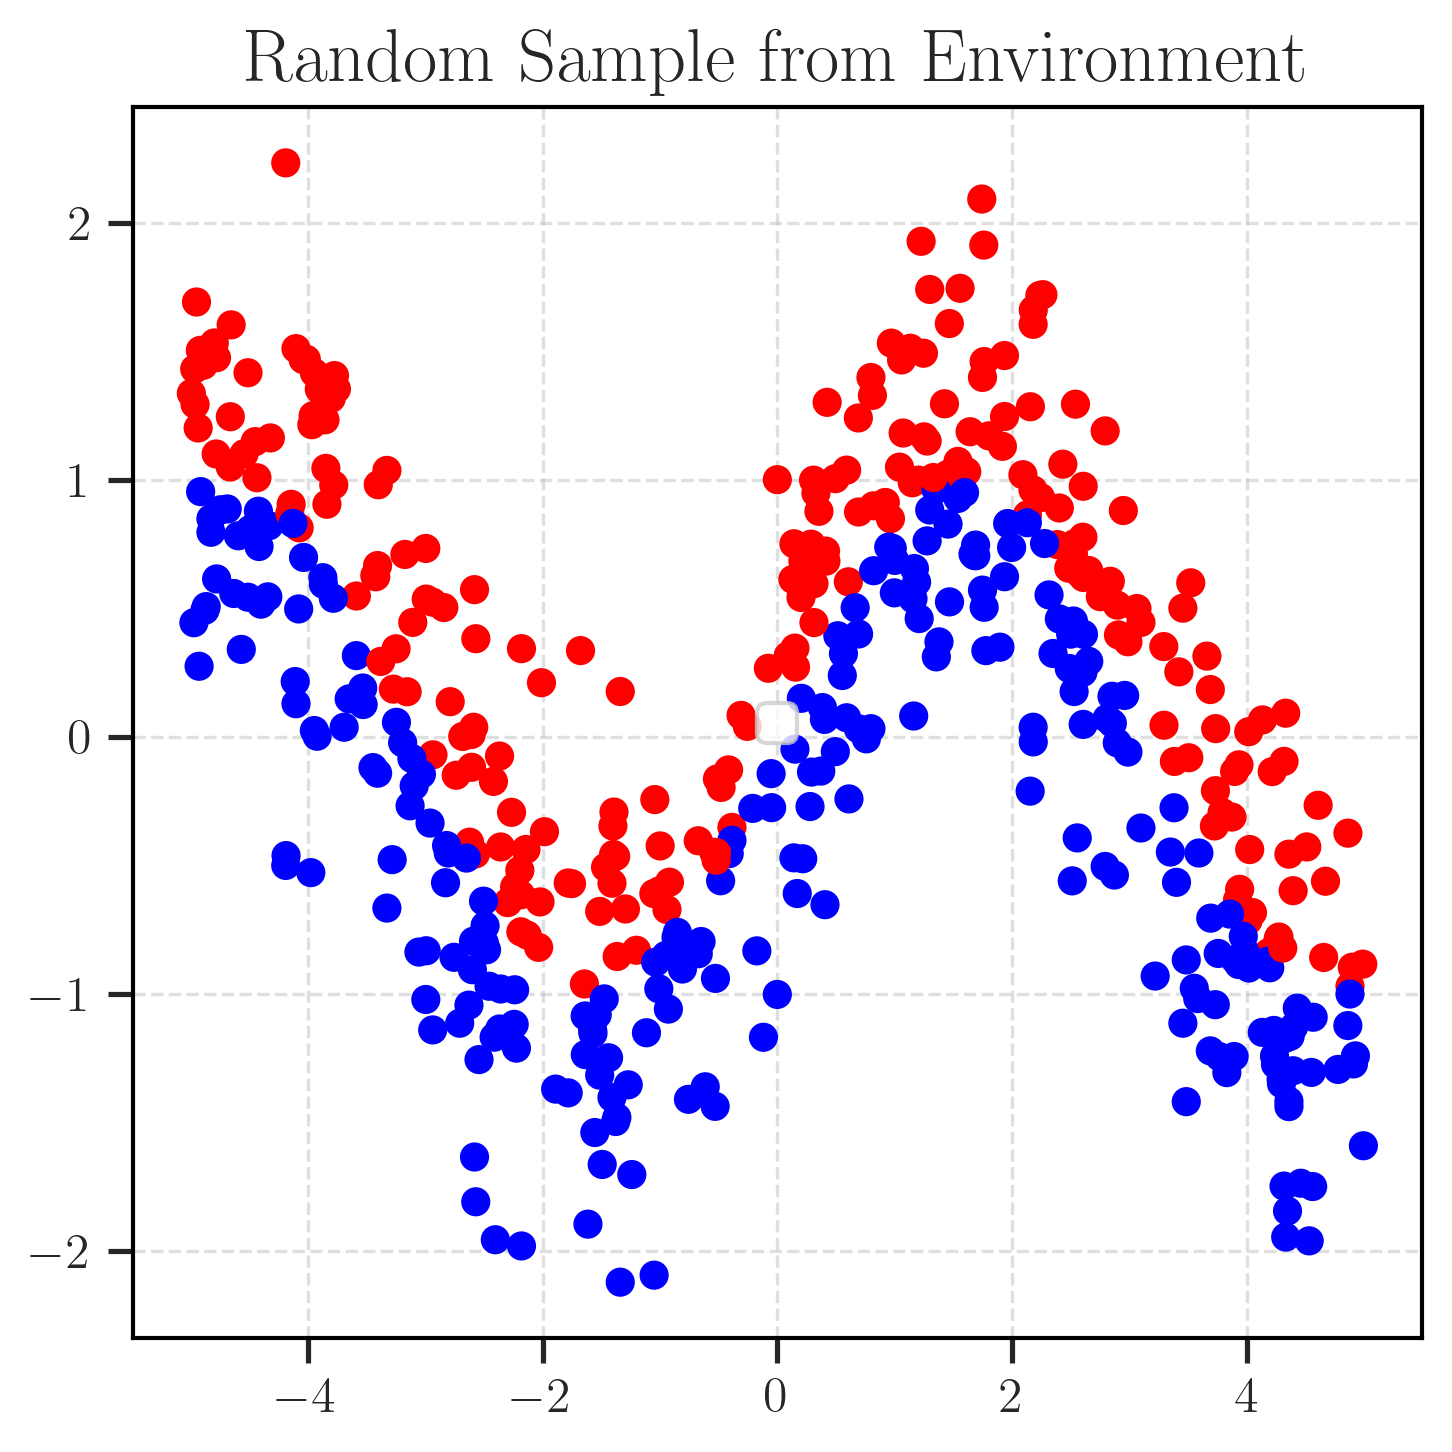

In [21]:
# --- 3. Sample a random batch from the environment and visualize ---
random_batch = env.sample_batch_joint(batch_size=500, train=True)
print(f"Sampled random batch - inputs shape: {random_batch[0].shape}, labels shape: {random_batch[1].shape}")
viz_utils.plot_2d_data(random_batch[0], random_batch[1], title="Random Sample from Environment")

Setting the model 

In [22]:
net_args = config['network']
net_args['num_classes_total'] = env.num_classes
network = networks.get_network_from_name(net_args['name'], **net_args).to(device)

Number of parameters 0.000502 MLN


In [23]:
# Init optimizer and scheduler
opt_args = config['optimizer']
sched_args = config['scheduler']
optimizer = utils.setup_optimizer(opt_args, network)
scheduler = utils.setup_scheduler(sched_args, optimizer)

In [24]:
# # --- Setup ---
# loss_fn = utils.loss_fn
# regularizer = get_regularizer(config)

# # --- Initialization ---
# replay_buffer = []
# results = {} # Will store { 0: {'reg':[], 'all':[]}, 1: {...}, ... }
# num_tasks = 9

# print(f"Running experiment: {config['reg_type']} (accumulate={config['accumulate']}) ")

# for t in range(num_tasks):
#     task_data = env.init_single_task(task_number=t, train=True)
#     task_loader = DataLoader(task_data, batch_size=config["batch_size"], shuffle=True, num_workers=8)
    
#     print(f"\n--- Training on Task {t+1}/{num_tasks} ---")
    
#     task_iterator = itertools.cycle(task_loader)
    
#     # Trackers for this task
#     task_metrics = {
#         'reg': [], # Metrics for regularized samples
#         'all': []  # Metrics for all past samples
#     }

#     # --- Evaluate once before training (if past tasks exist) ---
#     if t > 0:
#         step_label = "BEFORE_TRAINING"
        
#         # 1. Evaluate regularized samples
#         per_sample_metrics = training.evaluate_past_metrics(network, regularizer, loss_fn, device)
#         task_metrics['reg'].append(per_sample_metrics)
#         mean_accuracy_reg = np.mean([m['accuracy'] for m in per_sample_metrics])
#         mean_forget_reg = np.mean([m['forgotten'] for m in per_sample_metrics]) # Using 'forgotten' as in your code

#         # 2. Evaluate all past samples
#         past_metrics_all = training.evaluate_on_all_past(network, replay_buffer, loss_fn, device)
#         task_metrics['all'].append(past_metrics_all)
        
#         # 3. Print combined log
#         tqdm.write(
#             f"  [T{t+1}, {step_label: >16}] | "
#             f"PAST-ALL Acc: {past_metrics_all['mean_accuracy']*100:6.2f}% | "
#             f"PAST-REG Acc: {mean_accuracy_reg*100:6.2f}%"
#         )

#     # --- Step loop for training and logging ---
#     num_chunks = config['num_steps'] // config['log_every_n_steps']
#     for chunk_idx in tqdm(range(num_chunks), desc=f'Task {t} chunks', total=num_chunks):
        
#         # 1. Train for a chunk of steps
#         avg_acc = training.train_task(
#             network, task_iterator, regularizer, optimizer, 
#             scheduler[0], loss_fn, 
#             num_steps=config['log_every_n_steps'], 
#             device=device
#         )
        
#         step = (chunk_idx + 1) * config['log_every_n_steps']
#         step_label = f"Step {step: >4}"
        
#         tqdm.write(f"  [T{t+1}, {step_label: >16}] | (CURR) Task Acc: {avg_acc*100:6.2f}%")

#         # 2. Evaluate metrics (if past data exists)
#         if t > 0: 
#             # 2a. Evaluate regularized samples
#             per_sample_metrics = training.evaluate_past_metrics(network, regularizer, loss_fn, device)
#             task_metrics['reg'].append(per_sample_metrics)
#             mean_accuracy_reg = np.mean([m['accuracy'] for m in per_sample_metrics])
#             mean_forget_reg = np.mean([m['forgotten'] for m in per_sample_metrics])

#             # 2b. Evaluate all past samples
#             past_metrics_all = training.evaluate_on_all_past(network, replay_buffer, loss_fn, device)
#             task_metrics['all'].append(past_metrics_all)
            
#             # 2c. Print combined log
#             tqdm.write(
#                 f"  [T{t+1}, {step_label: >16}] | "
#                 f"PAST-ALL Acc: {past_metrics_all['mean_accuracy']*100:6.2f}% | "
#                 f"PAST-REG Acc: {mean_accuracy_reg*100:6.2f}%"
#             )
    
#     # Store all metrics for this task
#     results[t] = task_metrics
    
#     # --- Post-Task Updates ---
#     print(f"Updating regularizer '{config['reg_type']}'...")
    
#     # 1. Subsample dataset for regularizer
#     frac = config.get('reg_subsample_frac', 1.0)
#     reg_update_dataset = utils.subsample_dataset(task_data, frac)
#     print(f"  > Regularizer update dataset size: {len(reg_update_dataset)} (frac={frac})")
    
#     # 2. Update the CL regularizer
#     regularizer.update(
#         network, 
#         reg_update_dataset,
#         loss_fn, 
#         accumulate=config['accumulate']
#     )

#     # 3. Update the full replay buffer
#     replay_buffer.append(task_data) 
    
# print("\n--- Experiment Finished ---")

visualizations

In [25]:
# # --- 4. Visualization (NEW) ---
# import viz_utils # <-- Import your plotting file

# # Make sure to reload it if you make changes
# %autoreload 2

# # === Plot 1: Comparison of REG 'forgetting' vs. ALL 'mean_accuracy' ===
# # This is the new plot you requested
# print("--- Plot 1: Mean 'forgetting' (REG) vs. Mean 'accuracy' (ALL) ---")
# viz_utils.plot_longitudinal_mean_comparison(
#     results=results, # Pass the main results dict
#     config=config,
#     metric_reg='accuracy',  # The per-sample metric in 'reg'
#     metric_all='mean_accuracy', # The mean metric in 'all'
#     num_tasks=9,
#     model_name="CL Model"
# )

# sample_ids_to_plot = [i*2 for i in range(15)]

# # === Plot 3: Individual Sample 'loss_error' (Kappa) ===
# print("\n--- Plot 3: Individual Sample 'loss_error' (Kappa) ---")
# viz_utils.plot_longitudinal_sample_history(
#     results=results,
#     config=config,
#     metric_to_plot='loss_error',
#     sample_ids_to_plot=sample_ids_to_plot, # Example IDs
#     num_tasks=9,
#     model_name="CL Model"
# )


# # === Plot 3: Individual Sample 'loss_error' (Kappa) ===
# print("\n--- Plot 3: Individual Sample 'loss_error' (Kappa) ---")
# viz_utils.plot_longitudinal_sample_history(
#     results=results,
#     config=config,
#     metric_to_plot='grad_norm_error',
#     sample_ids_to_plot=sample_ids_to_plot, # Example IDs
#     num_tasks=9,
#     model_name="CL Model"
# )


# # === Plot 3: Individual Sample 'loss_error' (Kappa) ===
# print("\n--- Plot 3: Individual Sample 'loss_error' (Kappa) ---")
# viz_utils.plot_longitudinal_sample_history(
#     results=results,
#     config=config,
#     metric_to_plot='grad_cos_sim',
#     sample_ids_to_plot=sample_ids_to_plot, # Example IDs
#     num_tasks=9,
#     model_name="CL Model"
# )

### Evaluating approximations on the same training trajectory 

In [ ]:
# In experiment_runner.py
import torch
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
import itertools
from tqdm.notebook import tqdm
import training
import utils_monitor

def run_experiment(config, env, network, optimizer, scheduler, training_mode='cl'):
    
    device = config['device']
    loss_fn = utils.loss_fn
    
    
    # Active Regularizer
    if training_mode == 'cl':
        cfg_copy = config.copy(); cfg_copy['alpha'] = 0.0
        active_regularizer = get_regularizer(cfg_copy)
    else:
        cfg_copy = config.copy(); cfg_copy['alpha'] = 0.0
        active_regularizer =  get_regularizer(cfg_copy)

    # Shadow Monitor
    shadow_monitor = utils_monitor.ShadowMonitor(config, loss_fn)
    
    replay_buffer = [] 
    results = {} 

    print(f"=== Starting Experiment: Mode={training_mode} ===")

    for t in range(config['environment_args']['num_tasks']):
        task_data = env.init_single_task(task_number=t, train=True)
        task_loader = DataLoader(task_data, batch_size=config["batch_size"], shuffle=True, num_workers=4)
        
        # --- Construct Training Loader ---
        if training_mode == 'replay' and len(replay_buffer) > 0:
            full_data = ConcatDataset(replay_buffer + [task_data])
            train_loader = DataLoader(full_data, batch_size=config["batch_size"], shuffle=True)
        else:
            train_loader = task_loader
            
        task_iterator = itertools.cycle(train_loader)
        task_metrics = {'history': []}

        # --- Training Loop ---
        num_chunks = config['num_steps'] // config['log_every_n_steps']
        
        # Initial eval before training
        if t > 0:
            monitor_stats = utils_monitor.evaluate_shadow_monitors(network, shadow_monitor, device)
            past_metrics_all = training.evaluate_on_all_past(network, replay_buffer, loss_fn, device)
            
            acc_reg = np.mean([m['accuracy'] for m in monitor_stats])
            
            tqdm.write(
                f"  [T{t+1}, BEFORE] | "
                f"PAST-ALL Acc: {past_metrics_all['mean_accuracy']*100:6.2f}%"
            )

        for chunk_idx in tqdm(range(num_chunks), desc=f'Task {t} ({training_mode})'):
            
            # A. Train
            avg_acc = training.train_task(
                network, task_iterator, active_regularizer, optimizer, 
                scheduler, loss_fn, config['log_every_n_steps'], device
            )
            
            step = (chunk_idx + 1) * config['log_every_n_steps']
            step_label = f"Step {step: >4}"
            
            # B. Evaluate & Print
            if t > 0:
                # 1. Monitor Stats (Past Reg samples)
                monitor_stats = utils_monitor.evaluate_shadow_monitors(network, shadow_monitor, device)
                task_metrics['history'].append(monitor_stats)
                
                acc_reg = np.mean([m['accuracy'] for m in monitor_stats])
                
                # 2. General Past Stats (Replay Buffer samples)
                past_metrics_all = training.evaluate_on_all_past(network, replay_buffer, loss_fn, device)
                
                # 3. Print
                tqdm.write(
                    f"  [T{t+1}, {step_label}] | "
                    f"CURR Acc: {avg_acc*100:6.2f}% "
                    f"PAST-REG Acc: {acc_reg*100:6.2f}%"
                )
            else:
                # Task 0: Just print current accuracy
                tqdm.write(f"  [T{t+1}, {step_label}] | CURR Acc: {avg_acc*100:6.2f}%")

        results[t] = task_metrics

        # --- Post-Task Updates ---
        print(f"  > Task {t} Done. Sampling datasets...")

        # 1. Sample for Replay Buffer
        frac_replay = config.get('replay_frac', 0.1)
        ds_replay = utils.subsample_dataset(task_data, frac_replay)

        # 2. Sample for Regularizer/Monitor
        frac_reg = config.get('reg_frac', 0.05)
        ds_reg = utils.subsample_dataset(task_data, frac_reg)

        # 3. Update Active Regularizer
        if training_mode == 'cl':
            active_regularizer.update(network, ds_reg, loss_fn, accumulate=config['accumulate'])
            
        # 4. Update Shadow Monitor
        shadow_monitor.update(network, ds_reg)
        
        # 5. Update Replay Buffer
        replay_buffer.append(ds_replay)
        
    return results

In [27]:
network = networks.get_network_from_name(net_args['name'], **net_args).to(device)
# Init optimizer and scheduler
optimizer = utils.setup_optimizer(opt_args, network)
scheduler = utils.setup_scheduler(sched_args, optimizer)

# --- Run 1: Continual Learning (Training with Regularizer) ---
results_cl = run_experiment(
    config, env, network, optimizer, scheduler[0],
    training_mode='cl'
)

# network = networks.get_network_from_name(net_args['name'], **net_args).to(device)
# # Init optimizer and scheduler
# optimizer = utils.setup_optimizer(opt_args, network)
# scheduler = utils.setup_scheduler(sched_args, optimizer)

# # --- Run 2: Replay (Training with History, No Regularizer) ---
# results_replay = run_experiment(
#     config, env, network, optim, 
#     training_mode='replay'
# )


Number of parameters 0.000502 MLN
=== Starting Experiment: Mode=cl ===


Task 0 (cl):   0%|          | 0/100 [00:00<?, ?it/s]

  [T1, Step    1] | CURR Acc:  53.12%
  [T1, Step    2] | CURR Acc:  37.50%
  [T1, Step    3] | CURR Acc:  56.25%
  [T1, Step    4] | CURR Acc:  50.00%
  [T1, Step    5] | CURR Acc:  62.50%
  [T1, Step    6] | CURR Acc:  68.75%
  [T1, Step    7] | CURR Acc:  87.50%
  [T1, Step    8] | CURR Acc:  53.12%
  [T1, Step    9] | CURR Acc:  59.38%
  [T1, Step   10] | CURR Acc:  43.75%
  [T1, Step   11] | CURR Acc:  56.25%
  [T1, Step   12] | CURR Acc:  87.50%
  [T1, Step   13] | CURR Acc:  53.12%
  [T1, Step   14] | CURR Acc:  12.50%
  [T1, Step   15] | CURR Acc:  65.62%
  [T1, Step   16] | CURR Acc:  87.50%
  [T1, Step   17] | CURR Acc:  87.50%
  [T1, Step   18] | CURR Acc:  75.00%
  [T1, Step   19] | CURR Acc:  78.12%
  [T1, Step   20] | CURR Acc:  75.00%
  [T1, Step   21] | CURR Acc: 100.00%
  [T1, Step   22] | CURR Acc:  84.38%
  [T1, Step   23] | CURR Acc:  96.88%
  [T1, Step   24] | CURR Acc: 100.00%
  [T1, Step   25] | CURR Acc:  96.88%
  [T1, Step   26] | CURR Acc:  90.62%
  [T1, Step 

Task 1 (cl):   0%|          | 0/100 [00:00<?, ?it/s]

  [T2, Step    1] | CURR Acc:  71.88% PAST-REG Acc: 100.00%
  [T2, Step    2] | CURR Acc:  78.12% PAST-REG Acc: 100.00%
  [T2, Step    3] | CURR Acc:  65.62% PAST-REG Acc: 100.00%
  [T2, Step    4] | CURR Acc:  71.88% PAST-REG Acc: 100.00%
  [T2, Step    5] | CURR Acc:  75.00% PAST-REG Acc: 100.00%
  [T2, Step    6] | CURR Acc:  81.25% PAST-REG Acc: 100.00%
  [T2, Step    7] | CURR Acc:  50.00% PAST-REG Acc: 100.00%
  [T2, Step    8] | CURR Acc:  71.88% PAST-REG Acc: 100.00%
  [T2, Step    9] | CURR Acc:  78.12% PAST-REG Acc: 100.00%
  [T2, Step   10] | CURR Acc:  68.75% PAST-REG Acc: 100.00%
  [T2, Step   11] | CURR Acc:  71.88% PAST-REG Acc: 100.00%
  [T2, Step   12] | CURR Acc:  75.00% PAST-REG Acc: 100.00%
  [T2, Step   13] | CURR Acc:  81.25% PAST-REG Acc: 100.00%
  [T2, Step   14] | CURR Acc:  50.00% PAST-REG Acc: 100.00%
  [T2, Step   15] | CURR Acc:  75.00% PAST-REG Acc: 100.00%
  [T2, Step   16] | CURR Acc:  90.62% PAST-REG Acc: 100.00%
  [T2, Step   17] | CURR Acc:  78.12% PA

Task 2 (cl):   0%|          | 0/100 [00:00<?, ?it/s]

  [T3, Step    1] | CURR Acc:  65.62% PAST-REG Acc:  90.00%
  [T3, Step    2] | CURR Acc:  68.75% PAST-REG Acc:  80.00%
  [T3, Step    3] | CURR Acc:  75.00% PAST-REG Acc:  80.00%
  [T3, Step    4] | CURR Acc:  84.38% PAST-REG Acc:  80.00%
  [T3, Step    5] | CURR Acc: 100.00% PAST-REG Acc:  80.00%
  [T3, Step    6] | CURR Acc:  96.88% PAST-REG Acc:  75.00%
  [T3, Step    7] | CURR Acc: 100.00% PAST-REG Acc:  65.00%
  [T3, Step    8] | CURR Acc: 100.00% PAST-REG Acc:  60.00%
  [T3, Step    9] | CURR Acc:  81.25% PAST-REG Acc:  55.00%
  [T3, Step   10] | CURR Acc:  90.62% PAST-REG Acc:  50.00%
  [T3, Step   11] | CURR Acc:  93.75% PAST-REG Acc:  50.00%
  [T3, Step   12] | CURR Acc:  93.75% PAST-REG Acc:  50.00%
  [T3, Step   13] | CURR Acc:  93.75% PAST-REG Acc:  50.00%
  [T3, Step   14] | CURR Acc: 100.00% PAST-REG Acc:  50.00%
  [T3, Step   15] | CURR Acc: 100.00% PAST-REG Acc:  50.00%
  [T3, Step   16] | CURR Acc:  81.25% PAST-REG Acc:  50.00%
  [T3, Step   17] | CURR Acc:  90.62% PA

Task 3 (cl):   0%|          | 0/100 [00:00<?, ?it/s]

  [T4, Step    1] | CURR Acc:  81.25% PAST-REG Acc:  63.33%
  [T4, Step    2] | CURR Acc:  84.38% PAST-REG Acc:  63.33%
  [T4, Step    3] | CURR Acc:  93.75% PAST-REG Acc:  63.33%
  [T4, Step    4] | CURR Acc:  78.12% PAST-REG Acc:  63.33%
  [T4, Step    5] | CURR Acc:  65.62% PAST-REG Acc:  63.33%
  [T4, Step    6] | CURR Acc:  78.12% PAST-REG Acc:  63.33%
  [T4, Step    7] | CURR Acc: 100.00% PAST-REG Acc:  63.33%
  [T4, Step    8] | CURR Acc:  81.25% PAST-REG Acc:  63.33%
  [T4, Step    9] | CURR Acc:  87.50% PAST-REG Acc:  63.33%
  [T4, Step   10] | CURR Acc:  93.75% PAST-REG Acc:  63.33%
  [T4, Step   11] | CURR Acc:  78.12% PAST-REG Acc:  63.33%
  [T4, Step   12] | CURR Acc:  68.75% PAST-REG Acc:  66.67%
  [T4, Step   13] | CURR Acc:  78.12% PAST-REG Acc:  63.33%
  [T4, Step   14] | CURR Acc: 100.00% PAST-REG Acc:  63.33%
  [T4, Step   15] | CURR Acc:  84.38% PAST-REG Acc:  73.33%
  [T4, Step   16] | CURR Acc:  90.62% PAST-REG Acc:  73.33%
  [T4, Step   17] | CURR Acc:  93.75% PA

Task 4 (cl):   0%|          | 0/100 [00:00<?, ?it/s]

  [T5, Step    1] | CURR Acc:  65.62% PAST-REG Acc:  70.00%
  [T5, Step    2] | CURR Acc:  56.25% PAST-REG Acc:  70.00%
  [T5, Step    3] | CURR Acc:  53.12% PAST-REG Acc:  70.00%
  [T5, Step    4] | CURR Acc:  65.62% PAST-REG Acc:  67.50%
  [T5, Step    5] | CURR Acc:  81.25% PAST-REG Acc:  57.50%
  [T5, Step    6] | CURR Acc:  84.38% PAST-REG Acc:  57.50%
  [T5, Step    7] | CURR Acc:  75.00% PAST-REG Acc:  57.50%
  [T5, Step    8] | CURR Acc:  75.00% PAST-REG Acc:  57.50%
  [T5, Step    9] | CURR Acc:  90.62% PAST-REG Acc:  57.50%
  [T5, Step   10] | CURR Acc:  96.88% PAST-REG Acc:  57.50%
  [T5, Step   11] | CURR Acc:  84.38% PAST-REG Acc:  57.50%
  [T5, Step   12] | CURR Acc:  90.62% PAST-REG Acc:  57.50%
  [T5, Step   13] | CURR Acc:  90.62% PAST-REG Acc:  70.00%
  [T5, Step   14] | CURR Acc:  87.50% PAST-REG Acc:  70.00%
  [T5, Step   15] | CURR Acc:  84.38% PAST-REG Acc:  70.00%
  [T5, Step   16] | CURR Acc:  96.88% PAST-REG Acc:  70.00%
  [T5, Step   17] | CURR Acc:  90.62% PA

Task 5 (cl):   0%|          | 0/100 [00:00<?, ?it/s]

  [T6, Step    1] | CURR Acc:  96.88% PAST-REG Acc:  74.00%
  [T6, Step    2] | CURR Acc:  75.00% PAST-REG Acc:  74.00%
  [T6, Step    3] | CURR Acc:  84.38% PAST-REG Acc:  74.00%
  [T6, Step    4] | CURR Acc:  81.25% PAST-REG Acc:  74.00%
  [T6, Step    5] | CURR Acc:  81.25% PAST-REG Acc:  74.00%
  [T6, Step    6] | CURR Acc:  84.38% PAST-REG Acc:  74.00%
  [T6, Step    7] | CURR Acc: 100.00% PAST-REG Acc:  74.00%
  [T6, Step    8] | CURR Acc:  96.88% PAST-REG Acc:  74.00%
  [T6, Step    9] | CURR Acc:  75.00% PAST-REG Acc:  74.00%
  [T6, Step   10] | CURR Acc:  84.38% PAST-REG Acc:  74.00%
  [T6, Step   11] | CURR Acc:  81.25% PAST-REG Acc:  74.00%
  [T6, Step   12] | CURR Acc:  87.50% PAST-REG Acc:  74.00%
  [T6, Step   13] | CURR Acc:  90.62% PAST-REG Acc:  74.00%
  [T6, Step   14] | CURR Acc: 100.00% PAST-REG Acc:  74.00%
  [T6, Step   15] | CURR Acc:  90.62% PAST-REG Acc:  74.00%
  [T6, Step   16] | CURR Acc:  71.88% PAST-REG Acc:  74.00%
  [T6, Step   17] | CURR Acc:  81.25% PA

Task 6 (cl):   0%|          | 0/100 [00:00<?, ?it/s]

  [T7, Step    1] | CURR Acc:  62.50% PAST-REG Acc:  70.00%
  [T7, Step    2] | CURR Acc:  84.38% PAST-REG Acc:  70.00%
  [T7, Step    3] | CURR Acc:  90.62% PAST-REG Acc:  70.00%
  [T7, Step    4] | CURR Acc:  87.50% PAST-REG Acc:  70.00%
  [T7, Step    5] | CURR Acc:  81.25% PAST-REG Acc:  68.33%
  [T7, Step    6] | CURR Acc:  78.12% PAST-REG Acc:  65.00%
  [T7, Step    7] | CURR Acc: 100.00% PAST-REG Acc:  65.00%
  [T7, Step    8] | CURR Acc:  96.88% PAST-REG Acc:  65.00%
  [T7, Step    9] | CURR Acc:  75.00% PAST-REG Acc:  65.00%
  [T7, Step   10] | CURR Acc:  78.12% PAST-REG Acc:  65.00%
  [T7, Step   11] | CURR Acc:  87.50% PAST-REG Acc:  60.00%
  [T7, Step   12] | CURR Acc:  43.75% PAST-REG Acc:  65.00%
  [T7, Step   13] | CURR Acc:  87.50% PAST-REG Acc:  63.33%
  [T7, Step   14] | CURR Acc:  87.50% PAST-REG Acc:  63.33%
  [T7, Step   15] | CURR Acc:  90.62% PAST-REG Acc:  61.67%
  [T7, Step   16] | CURR Acc:  84.38% PAST-REG Acc:  63.33%
  [T7, Step   17] | CURR Acc:  84.38% PA

Task 7 (cl):   0%|          | 0/100 [00:00<?, ?it/s]

  [T8, Step    1] | CURR Acc:  50.00% PAST-REG Acc:  62.86%
  [T8, Step    2] | CURR Acc:  68.75% PAST-REG Acc:  62.86%
  [T8, Step    3] | CURR Acc:  59.38% PAST-REG Acc:  62.86%
  [T8, Step    4] | CURR Acc:  65.62% PAST-REG Acc:  62.86%
  [T8, Step    5] | CURR Acc:  65.62% PAST-REG Acc:  62.86%
  [T8, Step    6] | CURR Acc:  56.25% PAST-REG Acc:  62.86%
  [T8, Step    7] | CURR Acc:  87.50% PAST-REG Acc:  62.86%
  [T8, Step    8] | CURR Acc:  56.25% PAST-REG Acc:  64.29%
  [T8, Step    9] | CURR Acc:  71.88% PAST-REG Acc:  64.29%
  [T8, Step   10] | CURR Acc:  59.38% PAST-REG Acc:  65.71%
  [T8, Step   11] | CURR Acc:  71.88% PAST-REG Acc:  65.71%
  [T8, Step   12] | CURR Acc:  75.00% PAST-REG Acc:  65.71%
  [T8, Step   13] | CURR Acc:  71.88% PAST-REG Acc:  65.71%
  [T8, Step   14] | CURR Acc: 100.00% PAST-REG Acc:  65.71%
  [T8, Step   15] | CURR Acc:  84.38% PAST-REG Acc:  65.71%
  [T8, Step   16] | CURR Acc:  90.62% PAST-REG Acc:  65.71%
  [T8, Step   17] | CURR Acc:  93.75% PA

Task 8 (cl):   0%|          | 0/100 [00:00<?, ?it/s]

  [T9, Step    1] | CURR Acc:  84.38% PAST-REG Acc:  56.25%
  [T9, Step    2] | CURR Acc:  81.25% PAST-REG Acc:  56.25%
  [T9, Step    3] | CURR Acc:  87.50% PAST-REG Acc:  53.75%
  [T9, Step    4] | CURR Acc:  75.00% PAST-REG Acc:  53.75%
  [T9, Step    5] | CURR Acc:  78.12% PAST-REG Acc:  58.75%
  [T9, Step    6] | CURR Acc:  87.50% PAST-REG Acc:  62.50%
  [T9, Step    7] | CURR Acc:  87.50% PAST-REG Acc:  60.00%
  [T9, Step    8] | CURR Acc:  96.88% PAST-REG Acc:  60.00%
  [T9, Step    9] | CURR Acc:  90.62% PAST-REG Acc:  60.00%
  [T9, Step   10] | CURR Acc:  90.62% PAST-REG Acc:  60.00%
  [T9, Step   11] | CURR Acc:  75.00% PAST-REG Acc:  58.75%
  [T9, Step   12] | CURR Acc:  87.50% PAST-REG Acc:  58.75%
  [T9, Step   13] | CURR Acc:  90.62% PAST-REG Acc:  60.00%
  [T9, Step   14] | CURR Acc: 100.00% PAST-REG Acc:  58.75%
  [T9, Step   15] | CURR Acc:  96.88% PAST-REG Acc:  57.50%
  [T9, Step   16] | CURR Acc:  93.75% PAST-REG Acc:  57.50%
  [T9, Step   17] | CURR Acc:  87.50% PA


--- Plot 4: Kappa Trajectories (Reset vs Accumulate) ---


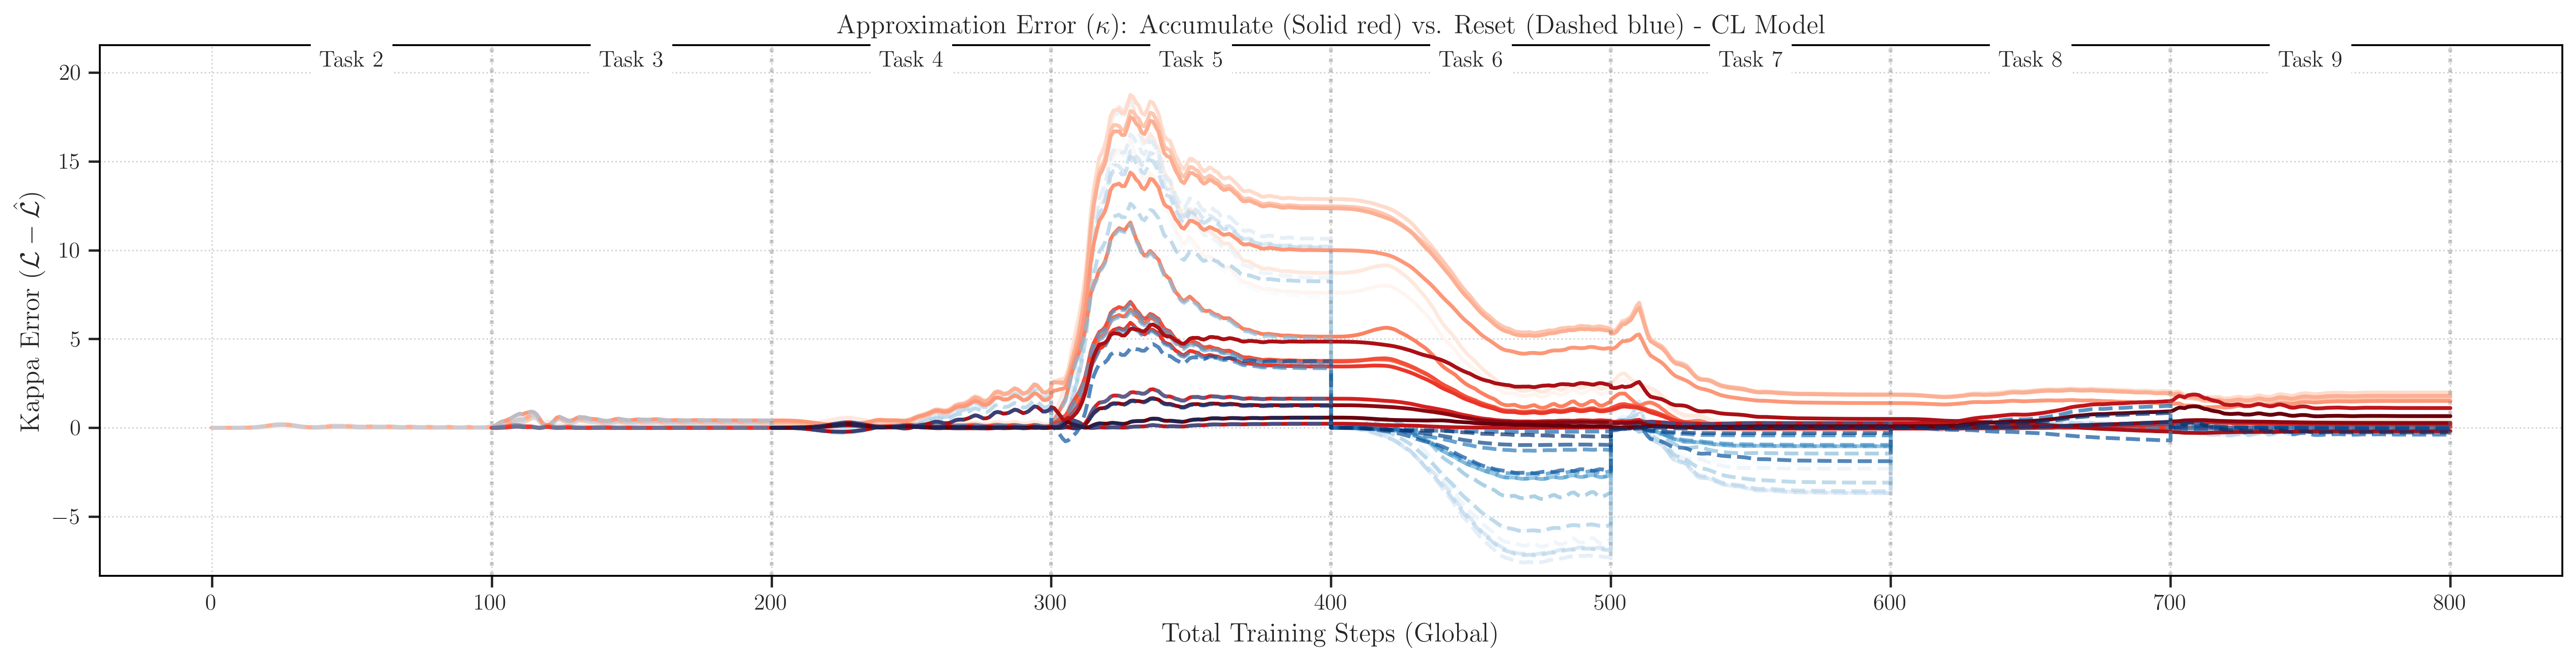

In [ ]:
print("\n--- Plot 4: Kappa Trajectories (Reset vs Accumulate) ---")

# Make sure to reload it if you make changes
%autoreload 2

# Define which samples you want to track
# Ideally, pick samples from early tasks (e.g., Task 0 or Task 1)
# to see their long-term behavior.
ids_to_track = [i*2 for i in range(15)]

viz_utils.plot_sample_error_trajectories(
    results=results_cl,      # Or results_replay
    config=config,
    num_tasks=9,
    sample_ids_to_plot=ids_to_track,
    model_name="CL Model"
)